In [1]:
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score

C:\Users\jorge\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load dataset folder
DatasetFolder = 'C:/Users/jorge/Desktop/github/img_processing/dog_muffin'
TrainData = DatasetFolder + '/train'
TestData = DatasetFolder + '/test'


In [3]:
# image transforms 
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
    ])

#batch size, data sets and loaders
batch_size = 8

trainset = torchvision.datasets.ImageFolder(root=TrainData, transform = transform)
testset = torchvision.datasets.ImageFolder(root=TestData, transform = transform)

trainloader = DataLoader(trainset, batch_size= batch_size, shuffle = True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle = True)

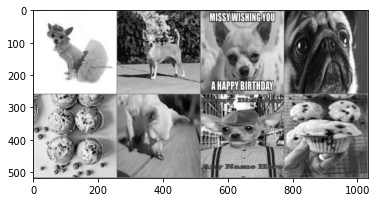

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images, nrow=4))

In [5]:
class binaryClassification(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3) 
        self.pool = nn.MaxPool2d(2,2) 
        self.conv2 = nn.Conv2d(6, 16, 3) 
        self.fc1 = nn.Linear(16 * 62 * 62, 128) 
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU
        
    
    def forward(self, x):
        x = self.conv1(x) 
        x = F.relu(x)
        x = self.pool(x) 
        x = self.conv2(x) 
        x = F.relu(x)
        x = self.pool(x) 

        x = torch.flatten(x, 1) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x) 
        x = F.relu(x)
        x = self.fc3(x) 

        x = self.sigmoid(x)

        return x

In [6]:
model = binaryClassification()      

lr = 0.001

loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []
print(model)

binaryClassification(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=61504, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [7]:
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # calc losses
        loss = loss_fn(outputs, labels.reshape(-1, 1).float())

        # backward pass
        loss.backward()
        
        # update weights
        optimizer.step()
        losses.append(float(loss.data.detach().numpy()))  
        if i % 100 == 0:
            sys.stdout.write(f'Step {i+1}/{len(trainloader)},'f'Loss: {loss.item():.4f}\n')
    sys.stdout.write(f'Epoch {epoch}/{NUM_EPOCHS},'f'Loss: {loss.item():.7f}\n')

Step 1/592,Loss: 0.6690
Step 101/592,Loss: 0.5535
Step 201/592,Loss: 0.3730
Step 301/592,Loss: 0.6869
Step 401/592,Loss: 0.3103
Step 501/592,Loss: 0.2633
Epoch 0/20,Loss: 0.6528030
Step 1/592,Loss: 0.5287
Step 101/592,Loss: 0.1278
Step 201/592,Loss: 0.5441
Step 301/592,Loss: 0.5935
Step 401/592,Loss: 0.3113
Step 501/592,Loss: 1.7150
Epoch 1/20,Loss: 0.5130351
Step 1/592,Loss: 0.3846
Step 101/592,Loss: 0.0468
Step 201/592,Loss: 0.0244
Step 301/592,Loss: 0.0795
Step 401/592,Loss: 0.0528
Step 501/592,Loss: 0.2172
Epoch 2/20,Loss: 0.1240231
Step 1/592,Loss: 0.0408
Step 101/592,Loss: 0.0282
Step 201/592,Loss: 0.0029
Step 301/592,Loss: 0.1024
Step 401/592,Loss: 0.0680
Step 501/592,Loss: 0.0008
Epoch 3/20,Loss: 0.0229374
Step 1/592,Loss: 0.0053
Step 101/592,Loss: 0.0061
Step 201/592,Loss: 0.0496
Step 301/592,Loss: 0.0002
Step 401/592,Loss: 0.0064
Step 501/592,Loss: 0.0035
Epoch 4/20,Loss: 0.3824308
Step 1/592,Loss: 0.0016
Step 101/592,Loss: 0.0001
Step 201/592,Loss: 0.0000
Step 301/592,Loss: 

<AxesSubplot:>

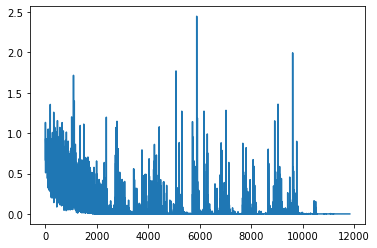

In [8]:
sns.lineplot(x= range(len(losses)), y = losses)

In [9]:
y_test = []
y_test_hat = []
for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        y_test_hat_temp = model(inputs).round()
    
    y_test.extend(y_test_temp.numpy())
    y_test_hat.extend(y_test_hat_temp.numpy())


acc = accuracy_score(y_test, y_test_hat)
print(f'Accuracy: {acc*100:.2f} %')



Accuracy: 82.01 %


In [11]:
model_path = 'C:/Users/jorge/Desktop/github/img_processing/binaryClass.pth'

torch.save(binaryClassification().state_dict(), model_path)


In [12]:
model.eval()

binaryClassification(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=61504, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)